# BIOE 245 – Machine Learning in Medical Imaging 

In this assignment you will build a complete deep learning pipeline. `testset.zip` (1.87GB) and `trainvalset.zip` (5.47GB) contain image data while `test_lab.csv` and `trainval_lab.csv` contain labels and demographic data. These are in a Box folder and will be downloaded directly into the Google Colab system in the scripts below. **The local google Colab filesystem gets deleted every 12ish hours, so you may need to rerun the scripts to redownload the data from Box if you leave the assignment and come back to it later.**

The goal of this assignment is to create a deep-learning model that will diagnose the presence and severity of radiographic osteoarthritis (KL) from cropped knee xray images. The dataset contains xrays of **one or both knees from 752 patients (565 patients in train/val, 187 patients in test) over several timepoints**. Each knee xray is evaluated by a radiologist and assigned a KL grade (from 0 to 4) which describes disease severity. The dataset we're working with is approximately 1/6th of the patients in the Osteoarthritis Initiative Dataset [ https://oai.epi-ucsf.org/datarelease/ ]. Distribution of KL grades is similar in trainval and testing sets.

KL | 0 | 1 | 2 | 3 | 4
--- | ---| ---| ---| ---| ---
 | no OA | doubtful OA | mild OA | moderate OA | severe OA

The easiest way to approach a new deep learning projects is doing it in parts:
1. Data download and characterization
2. Framing the learning problem
3. Network setup and training
4. Evaluation of results

(!!) Remember to activate GPUs by going to Runtime > Change Runtime Type and select GPU under Hardware Accelerator. Save checkpoints and download them frequently, as Colab runtime is not unlimited and training can time out.

---


In [ ]:
# ONLY NEED TO RUN THIS ONCE, AT THE BEGINNING OF EACH RUNTIME
# MOVEMENT OF FILES BETWEEN BOX –> COLAB SHOULD TAKE AT MOST 10 MINUTES

!curl -L https://ucsf.box.com/shared/static/o6rvx2fihrdz1ptqd50tgqy008nqz7r2 -o 'trainval_lab.csv'
!curl -L https://ucsf.box.com/shared/static/iiqos0z8iqee96mqq6vhak4ldzv57rw0 -o 'test_lab.csv'

!curl -L https://ucsf.box.com/shared/static/uqsc0e733fu8lrjhicnrkmyjftyw3hml -o 'testset.zip'
!curl -L https://ucsf.box.com/shared/static/edsxwcg6x0iwr6kyo15q08y2jz8t2u0y -o 'trainvalset.zip'

# make directories and unzip both trainval_set.zip and test_set.zip
!mkdir trainval
!mkdir test

!unzip -qq trainvalset.zip -d 'trainval' 
!unzip -qq testset.zip -d 'test'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     6    0     6    0     0      4      0 --:--:--  0:00:01 --:--:--     7
100  423k  100  423k    0     0   186k      0  0:00:02  0:00:02 --:--:--  669k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     6    0     6    0     0      4      0 --:--:--  0:00:01 --:--:--     0
100  144k  100  144k    0     0  81526      0  0:00:01  0:00:01 --:--:-- 81526
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the basic packages used throughout this assignment, 
# you are encouraged to import or pip install any other packages you might find useful
# (you can do this in a code cell by running !pip install my_package)

# NUMPY and visualization things
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline 
sns.set(color_codes=True)

# TENSORFLOW things
%tensorflow_version 2.x
import tensorflow.compat.v2 as tf
#import tensorflow_datasets as tfds
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

tf.keras.backend.clear_session() 

# handy function used later to read in .raw images from dataset
def load_im(im_path):
    raw_array = np.fromfile(im_path, dtype='float32')
    im = raw_array.reshape((500,500), order='C')
    return im

### 1. Data download and characterization
Understand your dataset and labels, perform data cleaning if necessary. Your loaded in .csv files contain several variables.

 raw_file | ID | months | side | race | gender | age | BMI | **KL**
 --- | --- | --- | --- | --- | --- | --- | --- | ---
xray | anon patient ID | xray timepoint (TP) |left/right knee| race| male/female| age @ TP | BMI @ TP | KL grade @ TP

<br>**Images**
>How many images are we working with in total? Are they 2D/3D? Multi-channel/single channel?
<br> Can you load in and plot a few images from the dataset?
<br> What does the intensity histogram of a few images look like? What range of values do these images contain? 
<br> What are "normal" variations in images? Are some flipped, rotated, inverted? Keep this in mind if you plan to implement augmentations in training.

<br> **Labels and demographics**
>What does the distribution of labels (KL) in the trainval dataset look like? How many observations are there per class?
<br> Does every image entry have a corresponding KL label?
<br> What are the demographics of this dataset? What is the mean age, BMI? What is the proportion of each race and gender?
<br> Is there an association between the demographic information and the KL label? 


In [ ]:
# labels loaded into a pandas dataframe
# see https://www.datacourses.com/tips-for-performing-eda-with-python-671/ for 
# information on exploratory data analysis using Pandas

trainval_df = pd.read_csv('trainval_lab.csv')
test_df = pd.read_csv('test_lab.csv')
f = len(test_df)
print(f)

2226


In [ ]:
trainval_df

,raw_file,ID,months,side,race,gender,age,BMI,KL
0,9000296_00_left_cropped.raw,9000296,0,left,1.0,1.0,69.0,29.8,3.0
1,9002411_00_left_cropped.raw,9002411,0,left,1.0,1.0,79.0,31.8,2.0
2,9003895_00_left_cropped.raw,9003895,0,left,1.0,2.0,70.0,28.4,2.0
3,9006407_00_left_cropped.raw,9006407,0,left,1.0,1.0,75.0,27.4,0.0
4,9008820_00_left_cropped.raw,9008820,0,left,1.0,2.0,51.0,21.0,0.0
...,...,...,...,...,...,...,...,...,...
6509,9966213_10_right_cropped.raw,9966213,96,right,1.0,2.0,81.0,31.9,1.0
6510,9975327_10_right_cropped.raw,9975327,96,right,1.0,1.0,71.0,31.3,NaN
6511,9979181_10_right_cropped.raw,9979181,96,right,1.0,1.0,61.0,25.4,1.0
6512,9988421_10_right_cropped.raw,9988421,96,right,2.0,2.0,63.0,22.9,2.0


In [ ]:
trainval_df_nonan = trainval_df.sort_values(by=['ID', 'months']).dropna(subset=['KL'])

In [ ]:
trainval_df_nonan

,raw_file,ID,months,side,race,gender,age,BMI,KL
0,9000296_00_left_cropped.raw,9000296,0,left,1.0,1.0,69.0,29.8,3.0
564,9000296_00_right_cropped.raw,9000296,0,right,1.0,1.0,69.0,29.8,2.0
1128,9000296_01_left_cropped.raw,9000296,12,left,1.0,1.0,70.0,29.4,3.0
1654,9000296_01_right_cropped.raw,9000296,12,right,1.0,1.0,70.0,29.4,2.0
3162,9000296_05_left_cropped.raw,9000296,36,left,1.0,1.0,72.0,28.8,3.0
...,...,...,...,...,...,...,...,...,...
2949,9998384_03_right_cropped.raw,9998384,24,right,1.0,2.0,74.0,18.9,3.0
3434,9998384_05_left_cropped.raw,9998384,36,left,1.0,2.0,75.0,18.6,2.0
3914,9998384_05_right_cropped.raw,9998384,36,right,1.0,2.0,75.0,18.6,4.0
4377,9998384_06_left_cropped.raw,9998384,48,left,1.0,2.0,76.0,18.5,2.0


In [ ]:
trainval_df_nonan

,raw_file,ID,months,side,race,gender,age,BMI,KL
0,9000296_00_left_cropped.raw,9000296,0,left,1.0,1.0,69.0,29.8,3.0
564,9000296_00_right_cropped.raw,9000296,0,right,1.0,1.0,69.0,29.8,2.0
1128,9000296_01_left_cropped.raw,9000296,12,left,1.0,1.0,70.0,29.4,3.0
1654,9000296_01_right_cropped.raw,9000296,12,right,1.0,1.0,70.0,29.4,2.0
3162,9000296_05_left_cropped.raw,9000296,36,left,1.0,1.0,72.0,28.8,3.0
...,...,...,...,...,...,...,...,...,...
2949,9998384_03_right_cropped.raw,9998384,24,right,1.0,2.0,74.0,18.9,3.0
3434,9998384_05_left_cropped.raw,9998384,36,left,1.0,2.0,75.0,18.6,2.0
3914,9998384_05_right_cropped.raw,9998384,36,right,1.0,2.0,75.0,18.6,4.0
4377,9998384_06_left_cropped.raw,9998384,48,left,1.0,2.0,76.0,18.5,2.0


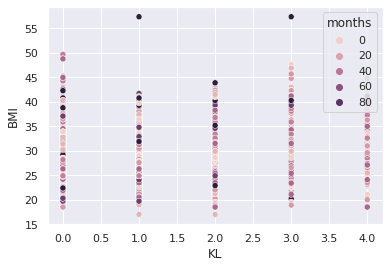

In [ ]:
sns.scatterplot(data=trainval_df_nonan, x='KL', y='BMI', hue='months')

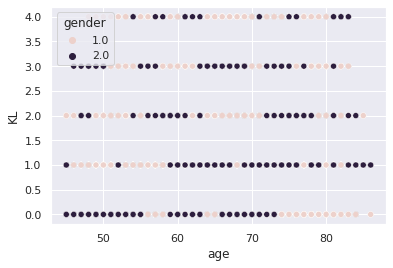

In [ ]:
sns.scatterplot(data=trainval_df_nonan, x='age', y='KL', hue='gender')

In [ ]:
trainval_df_nonan.groupby('ID').count()

,raw_file,months,side,race,gender,age,BMI,KL
ID,,,,,,,,
9000296,8,8,8,8,8,8,8,8
9002411,8,8,8,8,8,8,8,8
9003430,4,4,4,4,4,4,4,4
9003895,6,6,6,6,6,6,6,6
9005656,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...
9993261,8,8,8,8,8,8,8,8
9994408,10,10,10,10,10,10,10,10
9996284,14,14,14,14,14,14,14,14


In [ ]:
trainval_df_nonan.groupby(['ID']).agg({'raw_file':'first','side':'last','months':'last','BMI':'first','KL': 'first'})



,raw_file,side,months,BMI,KL
ID,,,,,
9000296,9000296_00_left_cropped.raw,right,48,29.8,3.0
9002411,9002411_00_left_cropped.raw,right,36,31.8,2.0
9003430,9003430_00_left_cropped.raw,right,48,30.0,0.0
9003895,9003895_00_left_cropped.raw,right,24,28.4,2.0
9005656,9005656_00_left_cropped.raw,right,12,38.1,0.0
...,...,...,...,...,...
9993261,9993261_00_left_cropped.raw,right,36,27.9,1.0
9994408,9994408_00_left_cropped.raw,right,48,28.6,2.0
9996284,9996284_00_left_cropped.raw,right,96,24.7,0.0


In [ ]:
trainval_df_nonan['BMI'].unique()

array([29.8, 29.4, 28.8, 28.4, 31.8, 32.6, 33.2, 33.9, 30. , 28.6, 28.7,
       38.1, 38. , 27.4, 26.9, 27.3, 26.7, 27.1, 26.8, 21. , 21.5, 22. ,
       20.6, 21.2, 21.7, 22.5, 23. , 22.1, 22.6, 22.3, 32.5, 33.1, 34.8,
       34.2, 28.2, 28.5, 31.3, 30.8, 20.8, 19.9, 19.7, 19.8, 20.5, 33. ,
       33.4, 29. , 30.2, 30.3, 30.6, 25.2, 27. , 28. , 34. , 36.5, 29.1,
       31.1, 20.1, 20.3, 18.6, 18.4, 35.7, 36.2, 36.8, 35.9, 35.3, 34.3,
       28.9, 24.4, 20.9, 20.7, 21.3, 24.1, 25.7, 25.1, 35.6, 37.4, 36.3,
       37.9, 34.6, 32.3, 20. , 21.1, 21.4, 30.1, 29.2, 29.9, 29.5, 20.4,
       19.2, 36.1, 36.9, 22.4, 20.2, 27.2, 27.7, 28.1, 26.5, 26.1, 24.9,
       23.5, 25.4, 24.5, 24. , 25.9, 29.7, 32.8, 31.4, 31.2, 19.6, 19.3,
       26.3, 27.6, 30.7, 34.7, 30.4, 25.8, 31.5, 33.5, 33.6, 33.8, 35.1,
       34.9, 30.9, 32. , 22.9, 22.7, 21.6, 29.3, 30.5, 29.6, 28.3, 32.9,
       34.5, 33.3, 27.9, 27.5, 25.5, 23.7, 44.2, 43.7, 44.9, 49.7, 48.8,
       57.4, 23.1, 23.4, 22.8, 22.2, 32.2, 31.6, 34

In [ ]:
trainval_groupID = trainval_df_nonan.groupby(['ID', 'side', 'months']).agg({'BMI':'first','KL': 'first'})

In [ ]:
trainval_groupID

BMI   KL
ID      side  months           
9000296 left  0       29.8  3.0
              12      29.4  3.0
              36      28.8  3.0
              48      28.4  3.0
        right 0       29.8  2.0
...                    ...  ...
9998384 right 0       19.5  3.0
              12      19.2  3.0
              24      18.9  3.0
              36      18.6  4.0
              48      18.5  4.0

[5850 rows x 2 columns]

In [ ]:
trainval_groupID.reset_index()

,ID,side,months,BMI,KL
0,9000296,left,0,29.8,3.0
1,9000296,left,12,29.4,3.0
2,9000296,left,36,28.8,3.0
3,9000296,left,48,28.4,3.0
4,9000296,right,0,29.8,2.0
...,...,...,...,...,...
5845,9998384,right,0,19.5,3.0
5846,9998384,right,12,19.2,3.0
5847,9998384,right,24,18.9,3.0
5848,9998384,right,36,18.6,4.0


In [ ]:
pat1 = trainval_groupID.loc[9000296].reset_index()

In [ ]:
pat1

,side,months,BMI,KL
0,left,0,29.8,3.0
1,left,12,29.4,3.0
2,left,36,28.8,3.0
3,left,48,28.4,3.0
4,right,0,29.8,2.0
5,right,12,29.4,2.0
6,right,36,28.8,2.0
7,right,48,28.4,2.0


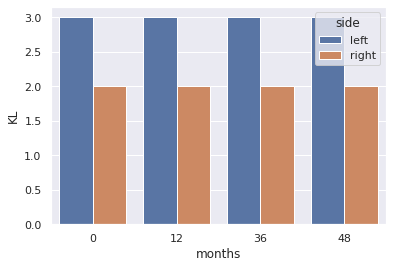

In [ ]:
sns.barplot(data=pat1, x='months', y='KL', hue='side')

In [ ]:
samp_knee = trainval_df_nonan.sample(30)

In [ ]:
samp_knee

,raw_file,ID,months,side,race,gender,age,BMI,KL
2282,9384183_03_left_cropped.raw,9384183,24,left,1.0,1.0,68.0,33.5,2.0
5217,9820271_08_left_cropped.raw,9820271,72,left,1.0,2.0,68.0,32.3,0.0
720,9504935_00_right_cropped.raw,9504935,0,right,1.0,1.0,53.0,30.4,2.0
4904,9379581_06_right_cropped.raw,9379581,48,right,2.0,1.0,58.0,33.4,2.0
5147,9519044_08_left_cropped.raw,9519044,72,left,1.0,2.0,60.0,25.9,3.0
2442,9924324_03_left_cropped.raw,9924324,24,left,1.0,2.0,60.0,27.6,0.0
3818,9658955_05_right_cropped.raw,9658955,36,right,1.0,1.0,77.0,29.8,1.0
248,9772627_00_left_cropped.raw,9772627,0,left,1.0,1.0,75.0,26.1,0.0
5941,9772627_10_left_cropped.raw,9772627,96,left,1.0,1.0,83.0,25.6,0.0
4027,9512864_05_right_cropped.raw,9512864,36,right,1.0,1.0,61.0,27.4,3.0


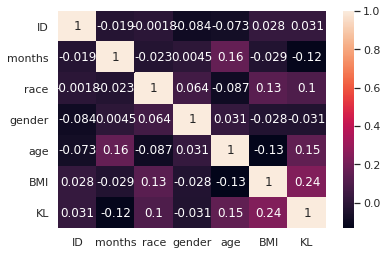

In [ ]:
sns.heatmap(trainval_df_nonan.corr(), annot=True)

Row:  1999
Total Patientes:  565
Col:  ['raw_file' 'ID' 'months' 'side' 'race' 'gender' 'age' 'BMI' 'KL']
Row:  5850
                          raw_file       ID  months  ...   age   BMI   KL
0      9000296_00_left_cropped.raw  9000296       0  ...  69.0  29.8  3.0
1      9002411_00_left_cropped.raw  9002411       0  ...  79.0  31.8  2.0
2      9003895_00_left_cropped.raw  9003895       0  ...  70.0  28.4  2.0
3      9006407_00_left_cropped.raw  9006407       0  ...  75.0  27.4  0.0
4      9008820_00_left_cropped.raw  9008820       0  ...  51.0  21.0  0.0
...                            ...      ...     ...  ...   ...   ...  ...
5845  9920140_10_right_cropped.raw  9920140      96  ...  56.0  40.3  3.0
5846  9948792_10_right_cropped.raw  9948792      96  ...  72.0  35.2  2.0
5847  9966213_10_right_cropped.raw  9966213      96  ...  81.0  31.9  1.0
5848  9979181_10_right_cropped.raw  9979181      96  ...  61.0  25.4  1.0
5849  9988421_10_right_cropped.raw  9988421      96  ...  63.0  22.9 

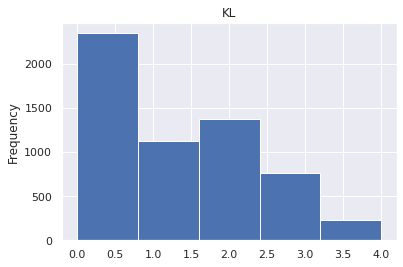

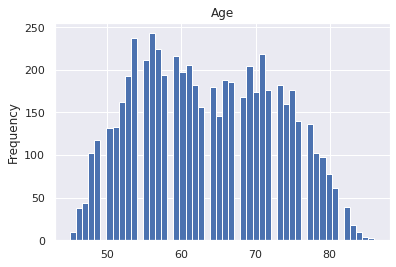

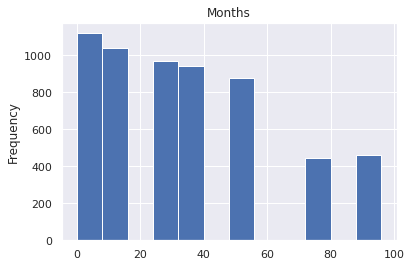

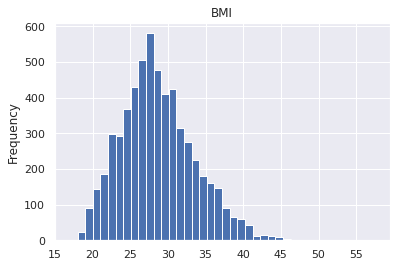

<Figure size 432x288 with 0 Axes>

In [ ]:
#see a sample of the data
# trainval_df.sample(50)
trainval_df = trainval_df.dropna(subset=['KL'])
trainval_df = trainval_df.reset_index(drop = True)
# trainval_df = trainval_df.sort_values(by = 'ID')

test_df = test_df.dropna(subset=['KL'])
test_df = test_df.reset_index(drop = True)
# test_df = test_df.sort_values(by = 'ID')


rowstst = len(test_df)
print('Row: ', rowstst)

patient_list = trainval_df.ID.unique()
rows2 = patient_list
num_patients = len(patient_list)
# columns2 = patient_list_df.columns.values
# print('Rows Patients 2', rows2)
print('Total Patientes: ', num_patients)
# print('Col Patients 2 :', columns2)

plt.figure()
trainval_df['KL'].plot(kind='hist', bins = 5)
plt.title('KL')
plt.figure()
trainval_df['age'].plot(kind='hist', bins = 50)
plt.title('Age')
plt.figure()
trainval_df['months'].plot(kind='hist', bins = 12)
plt.title('Months')
plt.figure()
trainval_df['BMI'].plot(kind='hist', bins = 40)
plt.title('BMI')
plt.figure()

patients = 0
columns = trainval_df.columns.values
rows = len(trainval_df)
print('Col: ', columns)
print('Row: ', rows)
# for column in df['ID']:
#   if df.iat[column,column] != df.iat[column,column + 1]:
#     patients += 1
# print(patients) 

print(trainval_df)
print (trainval_df.shape)

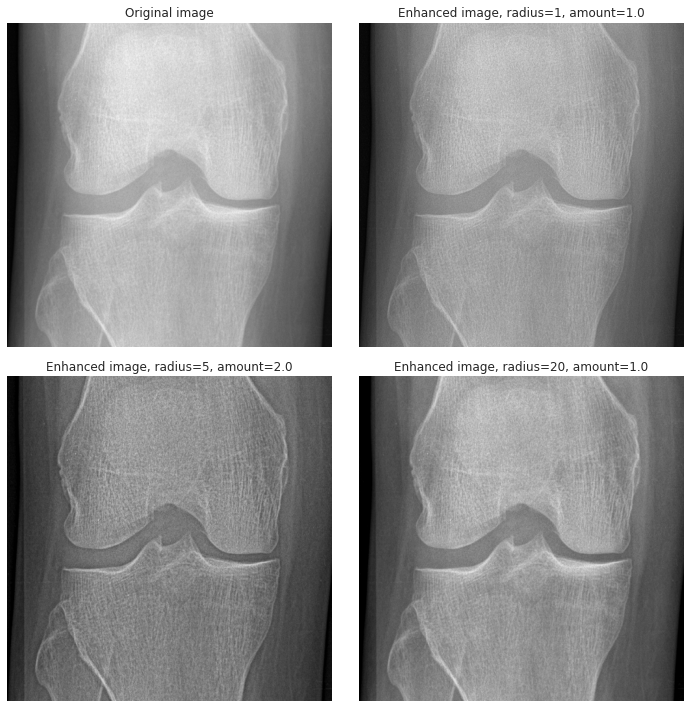

In [ ]:
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

image = load_im('/content/trainval/' + trainval_df.raw_file[650])
result_1 = unsharp_mask(image, radius=1, amount=1)
result_2 = unsharp_mask(image, radius=5, amount=2)
result_3 = unsharp_mask(image, radius=20, amount=1)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
sample_im = load_im('/content/trainval/'+trainval_df.raw_file[700])
print(np.shape(sample_im))

(500, 500)


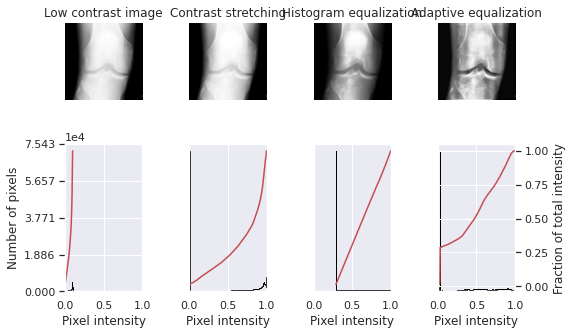

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = load_im('/content/trainval/'+trainval_df.raw_file[700])

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

shape of a single image (500, 500)


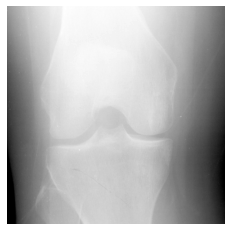

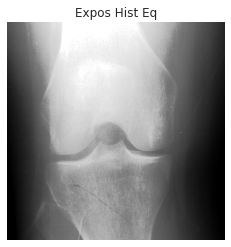

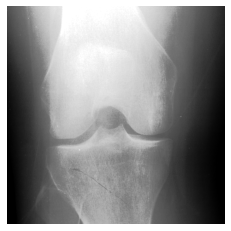

(500, 500)


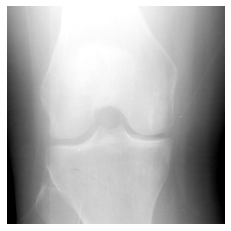

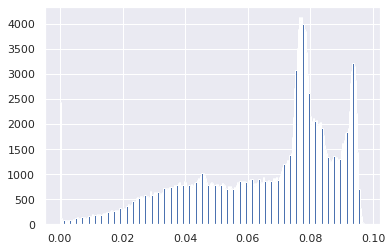

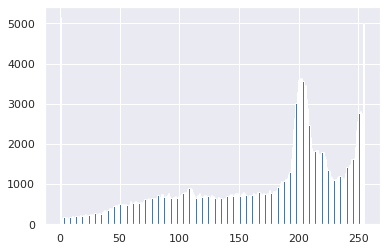

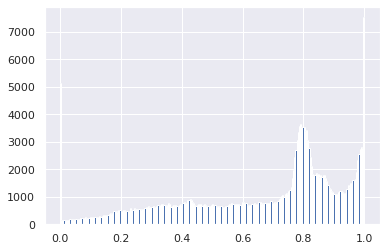

In [ ]:
from skimage import exposure
import cv2

sample_im = load_im('/content/trainval/'+trainval_df.raw_file[700])
print('shape of a single image', sample_im.shape)
plt.imshow(sample_im, cmap='gray')
plt.axis('off')
plt.show()

# Contrast Stretching
p2, p98 = np.percentile(sample_im, (2, 98))
img_rescale = exposure.rescale_intensity(sample_im, in_range=(p2, p98))

histequaliz = exposure.equalize_hist(img_rescale)
plt.imshow(histequaliz ,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Expos Hist Eq')
plt.show()
# print(np.shape(img_equaliz))



img1=np.uint8(cv2.normalize(img_rescale, None, 0, 255, cv2.NORM_MINMAX))
img_equal = cv2.equalizeHist(img1)
plt.figure()
plt.imshow(img_equal ,cmap=plt.cm.gray)
plt.axis('off')
plt.show()
print(np.shape(img1))


plt.imshow(img_rescale, cmap = 'gray')
plt.axis('off')
plt.show()

ax = plt.hist(sample_im.ravel(), bins = 256)
plt.show()

ax = plt.hist(img1.ravel(), bins = 256)
plt.show()

ax = plt.hist(img_rescale.ravel(), bins = 256)
plt.show()

### 2. Framing the learning problem
Create training and validation data splits (in the form of a `train_list` and a `validation_list`), choose type of deep-learning problem and an appropriate loss function. 

<br>**Splitting**
>Training and validation data is pooled so you'll need to define your own splitting heuristics. 
<br> Given that the dataset is large, would a random split be appropriate?
<br> Are there factors you need to account for when splitting the data? (Hint: compare total number of images against number of unique patients)
<br> Would you consider using a cross-validation scheme? How would you use this at test time?

<br>**Classification, Regression, or something else?**
>What type of learning problem can this be framed as? 
<br>What are the advantages/disadvantages of treating diagnosis as a classification problem? 
<br>What about a regression problem?
<br> What will the last network layer look like for each problem? What activation and loss functions?
<br> Reminder! Test data should not be touched until all experiments' training and validation are complete.

<br>**Auxilliary data**
>Is it possible that demographic data would improve the peformance of the network? How would you include this information? <br>Note: You are not expected to use the demographic data during training. 


In [ ]:
trainval_df_nonan.head(10)

,raw_file,ID,months,side,race,gender,age,BMI,KL
0,9000296_00_left_cropped.raw,9000296,0,left,1.0,1.0,69.0,29.8,3.0
564,9000296_00_right_cropped.raw,9000296,0,right,1.0,1.0,69.0,29.8,2.0
1128,9000296_01_left_cropped.raw,9000296,12,left,1.0,1.0,70.0,29.4,3.0
1654,9000296_01_right_cropped.raw,9000296,12,right,1.0,1.0,70.0,29.4,2.0
3162,9000296_05_left_cropped.raw,9000296,36,left,1.0,1.0,72.0,28.8,3.0
3642,9000296_05_right_cropped.raw,9000296,36,right,1.0,1.0,72.0,28.8,2.0
4122,9000296_06_left_cropped.raw,9000296,48,left,1.0,1.0,73.0,28.4,3.0
4580,9000296_06_right_cropped.raw,9000296,48,right,1.0,1.0,73.0,28.4,2.0
1,9002411_00_left_cropped.raw,9002411,0,left,1.0,1.0,79.0,31.8,2.0
565,9002411_00_right_cropped.raw,9002411,0,right,1.0,1.0,79.0,31.8,2.0


In [ ]:
idtemp = []
for ID in trainval_df_nonan['ID']:
  if ID not in idtemp:
    idtemp.append(ID)
print(len(idtemp))

565


In [ ]:
trainval_df_nonan

,raw_file,ID,months,side,race,gender,age,BMI,KL
0,9000296_00_left_cropped.raw,9000296,0,left,1.0,1.0,69.0,29.8,3.0
564,9000296_00_right_cropped.raw,9000296,0,right,1.0,1.0,69.0,29.8,2.0
1128,9000296_01_left_cropped.raw,9000296,12,left,1.0,1.0,70.0,29.4,3.0
1654,9000296_01_right_cropped.raw,9000296,12,right,1.0,1.0,70.0,29.4,2.0
3162,9000296_05_left_cropped.raw,9000296,36,left,1.0,1.0,72.0,28.8,3.0
...,...,...,...,...,...,...,...,...,...
2949,9998384_03_right_cropped.raw,9998384,24,right,1.0,2.0,74.0,18.9,3.0
3434,9998384_05_left_cropped.raw,9998384,36,left,1.0,2.0,75.0,18.6,2.0
3914,9998384_05_right_cropped.raw,9998384,36,right,1.0,2.0,75.0,18.6,4.0
4377,9998384_06_left_cropped.raw,9998384,48,left,1.0,2.0,76.0,18.5,2.0


In [ ]:
val_pat = np.random.choice((trainval_df_nonan.ID.unique()), size=113)
# train_list = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(~trainval_df.ID.isin(val_pat))].raw_file).tolist()
train_pat = np.random.choice(trainval_df_nonan[~trainval_df_nonan.ID.isin(val_pat)].ID.unique(), size=452)
print(len(val_pat), len(train_pat))
# # train_pat
a = set(val_pat)
b = set(train_pat)
a.intersection(b)
def unique(list1):
 
    # intilize a null list
    unique_list = []
    dup = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
        else:
          dup.append(x)
    # print list
    print(len(unique_list))
    print('Dup:', dup)
    # for x in unique_list:
    #     print(x)
     
 
# driver code

print("the unique values from 1st list is")
unique(val_pat)
val_pat

113 452
the unique values from 1st list is
108
Dup: [9068453, 9169499, 9200014, 9472254, 9505140]


array([9027281, 9559476, 9119057, 9811924, 9282772, 9986838, 9155943,
       9601644, 9169499, 9174216, 9036948, 9966213, 9142030, 9929413,
       9544698, 9426339, 9894184, 9673972, 9050299, 9548815, 9866291,
       9654655, 9249780, 9039972, 9284795, 9508858, 9886575, 9428490,
       9392241, 9063823, 9249027, 9434520, 9599715, 9455361, 9326657,
       9606664, 9111399, 9596903, 9440518, 9068453, 9417841, 9200014,
       9820271, 9211800, 9954172, 9099440, 9946967, 9133694, 9487409,
       9157758, 9724015, 9384183, 9493338, 9068453, 9005656, 9289216,
       9169499, 9257385, 9268233, 9360034, 9161024, 9043894, 9472254,
       9779490, 9017252, 9107980, 9770003, 9604541, 9916542, 9378389,
       9485404, 9200014, 9609776, 9494408, 9466873, 9582125, 9754907,
       9859873, 9091131, 9350339, 9705415, 9572948, 9421302, 9414968,
       9473858, 9765432, 9124421, 9138467, 9505140, 9075939, 9856656,
       9575273, 9681593, 9697904, 9409550, 9686908, 9242544, 9267648,
       9472254, 9445

In [ ]:
# train_list
# train_list = []
# val_list = []

# print(trainval_df.loc[7,'ID'])
# print(trainval_df.loc[15,'ID'])

o = len(patient_list)
print(o)

# for i in range(len(patient_list)):
#   for j in range(len(trainval_df)):
#     if (patient_list[i] == trainval_df.loc[j,'ID']) and j < 4680:
#       train_list.append(trainval_df.loc[j])
#     elif (patient_list[i] == trainval_df.loc[j,'ID']) and j >= 4680:
#       val_list.append(trainval_df.loc[j])
      # print('Else: \n', patient_list[i])



# for i in range(len(patient_list)):
#   for j in range(len(trainval_df)):
#     if (patient_list[i] == trainval_df.loc[j,'ID']) and ((trainval_df.loc[j,'ID'] % 2) == 0):
#       train_list.append(trainval_df.loc[i])
#       # print(patient_list[i])
#       if (patient_list[i] != trainval_df.loc[j,'ID']):
#         break
#     else:
#       val_list.append(trainval_df.loc[i])
#       # print('Else: \n', patient_list[i])



# print(np.shape(train_list))
# print(np.shape(val_list))

# validation_list

np.random.seed(0)
val_pat = np.random.choice(trainval_df[~pd.isnull(trainval_df.KL)].ID.unique(),175)
train_list = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(~trainval_df.ID.isin(val_pat))].raw_file).tolist()
val_list = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(trainval_df.ID.isin(val_pat))].raw_file).tolist()
test_list = ('/content/test/'+test_df[~pd.isnull(test_df.KL)].raw_file).tolist()

print(np.shape(train_list))


565
(4250,)


In [ ]:
print(train_list[0:2])
# print(val_list[2])
# train_df = pd.DataFrame(train_list)
# val_df = pd.DataFrame(val_list)


['/content/trainval/9000296_00_left_cropped.raw', '/content/trainval/9002411_00_left_cropped.raw']


Cross Validation (Maybe)

In [ ]:
np.random.seed(0)
val_pat = np.random.choice(trainval_df[~pd.isnull(trainval_df.KL)].ID.unique(),175)
val_pat_2 = np.random.choice(trainval_df[~pd.isnull(trainval_df.KL)].ID.unique(),175)

# x = val_pat.ravel
# y = val_pat_2.ravel
count = 0

for x in range(len(val_pat)):
  if val_pat[x] == val_pat_2[x]:
    count += 1
print(count)

train_list = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(~trainval_df.ID.isin(val_pat))].raw_file).tolist()
val_list = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(trainval_df.ID.isin(val_pat))].raw_file).tolist()
train_list_2 = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(~trainval_df.ID.isin(val_pat_2))].raw_file).tolist()
val_list_2 = ('/content/trainval/'+trainval_df[(~pd.isnull(trainval_df.KL))&(trainval_df.ID.isin(val_pat_2))].raw_file).tolist()
test_list = ('/content/test/'+test_df[~pd.isnull(test_df.KL)].raw_file).tolist()

print(np.shape(val_pat))
print(np.shape(val_pat_2))

# print((val_pat))
# print((val_pat_2))

print('First Train:', np.shape(train_list))
print(np.shape(val_list))
print('Second Train:', np.shape(train_list_2))
print(np.shape(val_list_2))
print(np.shape(test_list))

### 3. Network setup and training

Build your dataloader, set up network architectures and choose callbacks (early stopping, saving, tensorboard, etc). 

**Network inputs**
> You can design custom architectures to accept any input size while off-the-shelf architectures (like MobileNetV2) may not support an arbitrary input size. 
<br> Have you made sure your input is sized correctly (height/width/channels) to be compatible with the architecture you chose?
<br> If you change your images to fit the input requirements for an off-the-shelf network, are the important imaging features still visible?
<br> How big are the imaging features in the knee dataset compared to the size of the convolutional kernels you are learning? 

**Model saving**
> Are you saving your outputs at regular intervals? (your last epoch may not be your best epoch) If epoch 30 gave you the best validation performance, but you trained until epoch 100, you need to have saved model weights early on.

**Bells and whistles**
> Start simple, overfit to your training data, then build in complexity. <br> Don't forget about the loss functions, optimizers, augmentations, and regularization strategies discussed in lecture.



In [ ]:
# train_list = ('/content/trainval/' + train_df[~pd.isnull(train_df.KL)].raw_file).tolist()
# val_list = ('/content/trainval/' + val_df[~pd.isnull(val_df.KL)].raw_file).tolist()
# print(train_list_dl[0:2])

def train_generator():
    for trainfile in train_list:
        img = np.expand_dims(load_im(trainfile),axis = 2)
        raw_file = trainfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file == raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def val_generator():
    for valfile in val_list:
        img = np.expand_dims(load_im(valfile),axis = 2)
        raw_file = valfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file ==  raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def test_generator():
    for testfile in test_list:
        img = np.expand_dims(load_im(testfile),axis=2)
        raw_file = testfile.split('/')[-1]
        label = np.array(test_df[test_df.raw_file==raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def set_shapes(img, label, im_shape=(500,500,1)):
    img.set_shape(im_shape)
    label.set_shape((1))
    return img, label

def histEqual(img, label):
    img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    img = cv2.equalizeHist(img)
    return img, label

def resize(img, label):
  img = tf.image.resize(img, [300, 300]) 
  return img, label

# example augmentation function
def augment(img,label):
    img= tf.image.flip_left_right(img)
    img= tf.image.flip_up_down(img)
    img = tf.image.per_image_standardization(img)
    return img, label

Cross Val Data Loaders

In [ ]:
# train_list = ('/content/trainval/' + train_df[~pd.isnull(train_df.KL)].raw_file).tolist()
# val_list = ('/content/trainval/' + val_df[~pd.isnull(val_df.KL)].raw_file).tolist()
# print(train_list_dl[0:2])

def train_generator():
    for trainfile in train_list:
        img = np.expand_dims(load_im(trainfile),axis = 2)
        raw_file = trainfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file == raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        # Here I am rying to do some contrast rescaling, not sure if this is the right place to do it
        # Tried adding it to augment, but it said cannot perform numpy operation on a Tensor
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)

        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def train_2_generator():
    for trainfile in train_list_2:
        img = np.expand_dims(load_im(trainfile),axis = 2)
        raw_file = trainfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file == raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def val_generator():
    for valfile in val_list:
        img = np.expand_dims(load_im(valfile),axis = 2)
        raw_file = valfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file ==  raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def val_2_generator():
    for valfile in val_list_2:
        img = np.expand_dims(load_im(valfile),axis = 2)
        raw_file = valfile.split('/')[-1]
        label = np.array(trainval_df[trainval_df.raw_file ==  raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def test_generator():
    for testfile in test_list:
        img = np.expand_dims(load_im(testfile),axis=2)
        raw_file = testfile.split('/')[-1]
        label = np.array(test_df[test_df.raw_file==raw_file].KL.iloc[0], ndmin=1, dtype=np.int16)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = exposure.equalize_hist(img)
        img = tf.convert_to_tensor(img, dtype=tf.float32, name='img')
        label = tf.convert_to_tensor(label, dtype=tf.int16, name='label')
        yield img, label

def set_shapes(img, label, im_shape=(500,500,1)):
    img.set_shape(im_shape)
    label.set_shape((1))
    return img, label

def histEqual(img, label):
    img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    img = cv2.equalizeHist(img)
    return img, label

def resize(img, label):
  img = tf.image.resize(img, [300, 300]) 
  return img, label

# example augmentation function
def augment(img,label):
    img= tf.image.flip_left_right(img)
    img= tf.image.flip_up_down(img)
    img = tf.image.per_image_standardization(img)
    return img, label

In [ ]:


# test_list = ('/content/test/'+test_df[~pd.isnull(test_df.KL)].raw_file).tolist()

ds_train = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.int16))
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(buffer_size = len(train_list))
ds_train = ds_train.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.map(histEqual, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size = 5, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_train_2 = tf.data.Dataset.from_generator(train_2_generator, (tf.float32, tf.int16))
ds_train_2 = ds_train_2.cache()
# ds_train = ds_train.shuffle(buffer_size = len(train_list))
ds_train_2 = ds_train_2.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.map(histEqual, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_2 = ds_train_2.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_2 = ds_train_2.batch(batch_size = 5, drop_remainder=True)
ds_train_2 = ds_train_2.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tf.data.Dataset.from_generator(val_generator, (tf.float32, tf.int16))
ds_val = ds_val.cache()
ds_val = ds_val.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_val = ds_val.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size = 5, drop_remainder=True)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_val_2 = tf.data.Dataset.from_generator(val_2_generator, (tf.float32, tf.int16))
ds_val_2 = ds_val_2.cache()
ds_val_2 = ds_val_2.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_val = ds_val.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val_2 = ds_val_2.batch(batch_size = 5, drop_remainder=True)
ds_val_2 = ds_val_2.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)
print(ds_train_2)
print(ds_val_2)

ds_test = tf.data.Dataset.from_generator(test_generator, (tf.float32, tf.int16))
ds_test = ds_test.cache()
ds_test = ds_test.map(lambda img, label: set_shapes(img, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size = 5, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# ds_test = ds_test.take(1) # take one batch and inspect it
for image, label in ds_test.take(1):
  lab = label.numpy()
  im = image.numpy()
  print(lab.shape, im.shape)

for image, label in ds_train.take(1):
  lab = label.numpy()
  im = image.numpy()
  print(lab.shape, im.shape)

# in training, shuffling would go after the .cache() line:
# ds_train = ds_train.shuffle(buffer_size=len(train_list))

# preprocessing and/or augmentations (if training dataset) would go either after 
# the in the generator itself OR after the .map set_shapes line like so:
# ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
input_shape = (500, 500,1)
img_input = tf.keras.layers.Input(shape = input_shape)


model_12 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64,(5,5), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.6),
      # tf.keras.layers.Dense(512, activation='relu'),
      # tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
      ])

# model = tf.keras.Model(inputs=img_input)
model_12.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
history = model_12.fit(
    ds_train,
    epochs = 4,
    validation_data=ds_val,
    validation_freq=2,
    # callbacks = [callback]
    # class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_12.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_12 = np.argmax(model_12.predict(ds_test), axis=-1)
print(y_pred_model_1)

history_12 = model_12.fit(
    ds_train_2,
    epochs = 4,
    validation_data=ds_val_2,
    validation_freq=2,
    # callbacks = [callback]
    class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_12.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_12 = np.argmax(model2_1.predict(ds_test), axis=-1)
print(y_pred_model_12)


In [ ]:
from sklearn.metrics import confusion_matrix
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred_model_12)
print(d)

Non-Cross Val 

In [ ]:


# test_list = ('/content/test/'+test_df[~pd.isnull(test_df.KL)].raw_file).tolist()

ds_train = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.int16))
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(buffer_size = len(train_list))
ds_train = ds_train.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.map(histEqual, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(batch_size = 5, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tf.data.Dataset.from_generator(val_generator, (tf.float32, tf.int16))
ds_val = ds_val.cache()
ds_val = ds_val.map(lambda img, label: set_shapes(img, label), num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_val = ds_val.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size = 5, drop_remainder=True)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)

ds_test = tf.data.Dataset.from_generator(test_generator, (tf.float32, tf.int16))
ds_test = ds_test.cache()
ds_test = ds_test.map(lambda img, label: set_shapes(img, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.map(resize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size = 5, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# ds_test = ds_test.take(1) # take one batch and inspect it
for image, label in ds_test.take(1):
  lab = label.numpy()
  im = image.numpy()
  print(lab.shape, im.shape)

for image, label in ds_train.take(1):
  lab = label.numpy()
  im = image.numpy()
  print(lab.shape, im.shape)

# in training, shuffling would go after the .cache() line:
# ds_train = ds_train.shuffle(buffer_size=len(train_list))

# preprocessing and/or augmentations (if training dataset) would go either after 
# the in the generator itself OR after the .map set_shapes line like so:
# ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<PrefetchDataset shapes: ((5, 500, 500, 1), (5, 1)), types: (tf.float32, tf.int16)>
<PrefetchDataset shapes: ((5, 500, 500, 1), (5, 1)), types: (tf.float32, tf.int16)>


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


(5, 1) (5, 500, 500, 1)
(5, 1) (5, 500, 500, 1)


In [ ]:
# class MyCustomCallback(tf.keras.callbacks.Callback):
  
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3)
  # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  #     filepath= '/content/sample_data',
  #     save_weights_only=True,
  #     monitor='val_acc',
  #     mode='max',
  #     save_best_only=True)

Model 1: 

In [ ]:
input_shape = (500, 500,1)
img_input = tf.keras.layers.Input(shape = input_shape)


model_1 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64,(5,5), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.6),
      # tf.keras.layers.Dense(512, activation='relu'),
      # tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
      ])

# model = tf.keras.Model(inputs=img_input)
model_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
history = model_1.fit(
    ds_train,
    epochs = 8,
    validation_data=ds_val,
    validation_freq=2
    # class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_1.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_1 = np.argmax(model_1.predict(ds_test), axis=-1)
# y_predd = model.predict(ds_test)
# print(y_predd)
print(y_pred_model_1)

Epoch 1/8


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


850/850 [==============================] - 130s 153ms/step - loss: 1.3799 - accuracy: 0.4165
Epoch 2/8
850/850 [==============================] - 149s 176ms/step - loss: 1.2655 - accuracy: 0.4680 - val_loss: 1.4294 - val_accuracy: 0.4144
Epoch 3/8
850/850 [==============================] - 103s 121ms/step - loss: 1.1159 - accuracy: 0.5320
Epoch 4/8
850/850 [==============================] - 116s 136ms/step - loss: 0.9527 - accuracy: 0.6101 - val_loss: 1.4223 - val_accuracy: 0.4137
Epoch 5/8
850/850 [==============================] - 103s 121ms/step - loss: 0.7695 - accuracy: 0.6838
Epoch 6/8
850/850 [==============================] - 116s 136ms/step - loss: 0.6156 - accuracy: 0.7602 - val_loss: 1.4542 - val_accuracy: 0.3581
Epoch 7/8
850/850 [==============================] - 103s 121ms/step - loss: 0.4949 - accuracy: 0.8118
Epoch 8/8
399/399 [==============================] - 57s 142ms/step - loss: 1.5078 - accuracy: 0.3268

Test accuracy: 0.32681703567504883
[0 0 1 ... 0 2 2]


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred_model_1)
print(d)

kappa = cohen_kappa_scare(train_list_KL[0:1995],y_pred_model_1)

[[409 195  69 129  10]
 [180 100  46  55   9]
 [212 119  72  92  18]
 [ 54  48  41  61  11]
 [ 16  12   6  21  10]]


In [ ]:
model_1.save('/content/drive/My Drive/Model 1/Model1.h5')

{'loss': [1.3805694580078125, 1.2551134824752808, 1.1230331659317017, 0.9676307439804077, 0.8118795156478882, 0.6484990119934082, 0.5219103693962097, 0.4144333302974701], 'accuracy': [0.4108235239982605, 0.474823534488678, 0.5270588397979736, 0.5981176495552063, 0.6654117703437805, 0.7451764941215515, 0.7934117913246155, 0.8392941355705261], 'val_loss': [1.4028980731964111, 1.4261159896850586, 1.4001215696334839, 1.4556599855422974], 'val_accuracy': [0.4124999940395355, 0.41312500834465027, 0.3918749988079071, 0.34062498807907104]}


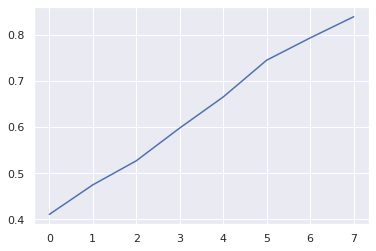

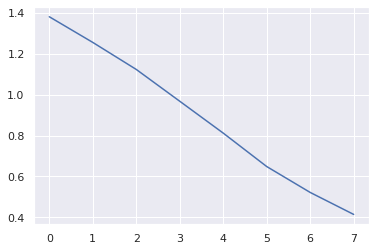

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

x = history.history
print(x)
plt.plot(history.history['accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.show()

# y_pred = np.argmax(model.predict(ds_test), axis=-1)
# y_predd = model.predict(ds_test)
# print(y_predd)
# print(y_pred)
# y_test = np.argmax(model.predict(ds_train), axis=-1)
# mat = confusion_matrix(y_test[0:1999], y_pred)
# plot_confusion_matrix(conf_mat = mat)
# print(y_test)


In [ ]:
plot_model(model)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 496, 496, 64)      1664      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 248, 248, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 244, 244, 64)      102464    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 58, 58, 128)      

Model 2

In [ ]:
input_shape = (500, 500,1)
img_input = tf.keras.layers.Input(shape = input_shape)


model_2 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64,(5,5), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.6),
      # tf.keras.layers.Dense(512, activation='relu'),
      # tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
      ])

# model = tf.keras.Model(inputs=img_input)
model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
history = model_2.fit(
    ds_train,
    epochs = 6,
    validation_data=ds_val,
    validation_freq=2,
    # callbacks = [callback],
    class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_2.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_2 = np.argmax(model_2.predict(ds_test), axis=-1)
# y_predd = model.predict(ds_test)
# print(y_predd)
print(y_pred_model_2)

Epoch 1/6


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


     94/Unknown - 601s 6s/step - loss: 1.3010 - accuracy: 0.2574

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred_model_2)
print(d)
kappa = cohen_kappa_scare(train_list_KL[0:1995],y_pred_model_2)

[[587  14  66 140   5]
 [310   6  37  35   2]
 [359  16  58  80   0]
 [152   4  25  33   1]
 [ 37   0  12  14   2]]


In [ ]:
model_2.save('/content/drive/My Drive/Model 2/Model2.h5')

In [ ]:
input_shape = (500, 500,1)
img_input = tf.keras.layers.Input(shape = input_shape)
regularizer = tf.keras.regularizers.l1(
    l=0.01
)

model_3 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64,(5,5), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_regularizer = regularizer),
      tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.Conv2D(128,(2,2), activation='relu'),
      # tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      # tf.keras.layers.Dense(512, activation='relu'),
      # tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.6),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.6),
      tf.keras.layers.Dense(5, activation='softmax')
      ])

# model = tf.keras.Model(inputs=img_input)
model_3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
history = model_3.fit(
    ds_train,
    epochs = 14,
    validation_data=ds_val,
    validation_freq=2,
    callbacks = [callback],
    # class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_3.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_3 = np.argmax(model_3.predict(ds_test), axis=-1)
y_predd = model_3.predict(ds_test)
print(y_predd)
print(y_pred)

Epoch 1/14
    850/Unknown - 48s 56ms/step - loss: 17.9090 - accuracy: 0.2911WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
850/850 [==============================] - 48s 56ms/step - loss: 17.9090 - accuracy: 0.2911
Epoch 2/14
850/850 [==============================] - 54s 64ms/step - loss: 1.9285 - accuracy: 0.3666 - val_loss: 1.5345 - val_accuracy: 0.4125
Epoch 3/14
850/850 [==============================] - 48s 56ms/step - loss: 1.4985 - accuracy: 0.3838
Epoch 4/14
850/850 [==============================] - 54s 63ms/step - loss: 1.4627 - accuracy: 0.3793 - val_loss: 1.4361 - val_accuracy: 0.4125
Epoch 5/14
850/850 [==============================] - 48s 57ms/step - loss: 1.4446 - accuracy: 0.3918
Epoch 6/14
850/850 [==============================] - 54s 63ms/step - loss: 1.4346 - accuracy: 0.3951 - val_loss: 1.4146 - val_accuracy: 0.4125
Epoch 7/14
850/850 [==============================] - 48s 56ms/

In [ ]:
from sklearn.metrics import confusion_matrix
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred_model_3)
print(d)
kappa = cohen_kappa_scare(train_list_KL[0:1995],y_pred_model_3)

[[812   0   0   0   0]
 [390   0   0   0   0]
 [513   0   0   0   0]
 [215   0   0   0   0]
 [ 65   0   0   0   0]]


Next Model

In [ ]:
input_shape = (500, 500,1)
img_input = tf.keras.layers.Input(shape = input_shape)


model_4 = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64,(5,5), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.6),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(5, activation='softmax')
      ])

# model = tf.keras.Model(inputs=img_input)
model_4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
history = model_4.fit(
    ds_train,
    epochs = 6,
    validation_data=ds_val,
    validation_freq=2,
    # callbacks = [callback],
    class_weight = {0:0.5, 1:0.7, 2:1.0, 3:1.4, 4:1.8}
)

test_loss, test_acc = model_4.evaluate(ds_test)
print('\nTest accuracy:', test_acc)

y_pred_model_4 = np.argmax(model_4.predict(ds_test), axis=-1)
# y_predd = model.predict(ds_test)
# print(y_predd)
print(y_pred_model_4)

In [ ]:
from sklearn.metrics import confusion_matrix
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred_model_4)
print(d)
kappa = cohen_kappa_scare(train_list_KL[0:1995],y_pred_model_4)

Another Model Attempt Branched This Time

In [ ]:
input_shape = (500, 500, 1)
img_input = tf.keras.layers.Input(shape = input_shape)

#define first input branch
largekernel_branch = tf.keras.models.Sequential()
largekernel_branch.add(tf.keras.layers.Conv2D(64,(5,5),
                       activation='relu',
                       input_shape=input_shape))
largekernel_branch.add(tf.keras.layers.MaxPooling2D())
largekernel_branch.add(tf.keras.layers.Flatten())
largekernel_branch.add(tf.keras.layers.Dropout(0.5))
largekernel_feat = largekernel_branch(img_input)


# Medium
mediumkernel_branch = tf.keras.models.Sequential()
mediumkernel_branch.add(tf.keras.layers.Conv2D(256,(4,4),
                       activation='relu',
                       input_shape=input_shape))
mediumkernel_branch.add(tf.keras.layers.MaxPooling2D())
mediumkernel_branch.add(tf.keras.layers.Flatten())
mediumkernel_branch.add(tf.keras.layers.Dropout(0.5))
mediumkernel_feat = largekernel_branch(img_input)


#define second input branch
smallkernel_branch = tf.keras.models.Sequential()
smallkernel_branch.add(tf.keras.layers.Conv2D(64,(3,3),
                       activation='relu',
                       input_shape=input_shape))
smallkernel_branch.add(tf.keras.layers.MaxPooling2D())
smallkernel_branch.add(tf.keras.layers.Flatten())
smallkernel_branch.add(tf.keras.layers.Dropout(0.5))
smallkernel_feat = smallkernel_branch(img_input)



merged = tf.keras.layers.concatenate([largekernel_feat, mediumkernel_feat, smallkernel_feat])
output = tf.keras.layers.Dense(5, activation='softmax')(merged)

branch_model = tf.keras.Model(inputs=img_input, outputs=output)
branch_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# you can train with .fit, .train_on_batch, GradientTape 
branch_model.fit(
    ds_train,
    epochs = 6,
    validation_data=ds_val,
    validation_freq=2
)

test_loss, test_acc = branch_model.evaluate(ds_test)
print('\nTest accuracy:', test_acc)
branch_model_pred = np.argmax(model_4.predict(ds_test), axis=-1)

Epoch 1/6


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


855/855 [==============================] - 178s 208ms/step - loss: 20.1251 - accuracy: 0.3295
Epoch 2/6
855/855 [==============================] - 226s 264ms/step - loss: 0.9080 - accuracy: 0.6681 - val_loss: 1.5637 - val_accuracy: 0.4249
Epoch 3/6
855/855 [==============================] - 176s 206ms/step - loss: 0.5781 - accuracy: 0.8186
Epoch 4/6
855/855 [==============================] - 209s 244ms/step - loss: 52.9622 - accuracy: 0.6354 - val_loss: 1.5369 - val_accuracy: 0.4261
Epoch 5/6
855/855 [==============================] - 178s 208ms/step - loss: 0.7071 - accuracy: 0.7751
Epoch 6/6
400/400 [==============================] - 58s 146ms/step - loss: 1.5089 - accuracy: 0.4012

Test accuracy: 0.4012005925178528


In [ ]:
branch_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 500, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3936256)      1664        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 3968064)      640         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7904320)      0           sequential_1[1][0]               
                                                                 sequential_2[1][0]           

In [ ]:
from sklearn.metrics import confusion_matrix
train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], branch_model_pred)
print(d)
kappa = cohen_kappa_scare(train_list_KL[0:1995], branch_model_pred)

In [ ]:
from sklearn.metrics import confusion_matrix

predls = []
truthls = []
labs = []

# label = np.array(test_df.KL.iloc[0], ndmin=1, dtype=np.int16)
print(np.shape(label))

# for i in range(len(test_df)):
#   labs = np.array(test_df.KL.iloc[i], ndmin=1, dtype=np.int16)
#   labs = labs.np.append(labs)


# train_list_KL = test_df['KL'].tolist()

for images, labels in ds_test.take(-1):
    lab = labels.numpy()
    predls.append(lab)
    im = images.numpy()
print(np.shape(predls))
print(np.shape(train_list_KL))
print(np.shape(y_pred))

# for images, labels in ds_train.take(-1):
#     lab1 = labels.numpy()
#     truthls.append(lab1)
#     im1 = images.numpy()


train_list_KL = test_df['KL'].tolist()
# print(np.shape(truthls))
d = confusion_matrix(train_list_KL[0:1995], y_pred)
print(d)

# con = tf.math.confusion_matrix(labels= [0,1,2,3,4], predictions=[0,1,2,3,4] )
# sess = tf.compat.v1.Session()
# with sess.as_default():
#         print(sess.run(con))

# # prediction = model()
# n_classes = 5

# correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
# con_mat = tf.confusion_matrix(labels=[0, 1, 2, 3, 4], predictions=correct, num_classes=n_classes, dtype=tf.int32, name=None)
# d = confusion_matrix(ds_val.take(1), ds_test.take(1))
# print(con_mat)

(5, 1)
(399, 5, 1)
(1999,)
(1995,)
[[428 231 123  23   7]
 [162 140  73  13   2]
 [197 135 131  35  15]
 [ 48  53  72  23  19]
 [ 14   9  18  15   9]]
